# Experimenting with loss functions and focal loss

In [1]:
import torch
import yaml
import wandb
import argparse
import numpy as np
import pandas as pd
import os
import sys

from copy import deepcopy
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from torch.optim import AdamW
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.nn import functional as F
from sklearn.metrics import roc_auc_score, roc_curve, auc


from utils import *

BASE_DIR = Path(os.path.abspath(''))
sys.path.append(str(BASE_DIR))
os.chdir(BASE_DIR)

# user-defined modules
from multimodal.models import BERT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

config = yaml.safe_load(open("config_MM.yaml"))
data_config = config['data']
defined_antibiotics = sorted(list(set(data_config['antibiotics']['abbr_to_names'].keys()) - set(data_config['exclude_antibiotics'])))
num_ab = len(defined_antibiotics)
ab_to_idx = {ab: idx for idx, ab in enumerate(defined_antibiotics)}
specials = config['specials']
max_seq_len = 56

## Load and prepare datasets

In [2]:
ds_path = data_config['TESSy']['load_path']
ds_TESSy = pd.read_pickle(ds_path)
ds_NCBI = pd.read_pickle(data_config['NCBI']['load_path'])
ds_MM = ds_NCBI[ds_NCBI['num_ab'] > 1].reset_index(drop=True)
print(f"Total number of samples in TESSy: {len(ds_TESSy):,}")

antibiotics = ['CAZ', 'CIP', 'AMP', 'GEN']
ds_CAZ = ds_TESSy.copy()
ds_CAZ = ds_CAZ[ds_CAZ['phenotypes'].apply(lambda x: all([ab in [p.split('_')[0] for p in x] for ab in antibiotics]))].reset_index(drop=True)
ds_CAZ['phenotypes'] = ds_CAZ['phenotypes'].apply(lambda x: [p for p in x if p.split('_')[0] in antibiotics])
ds_CAZ.drop(columns=['num_R', 'num_S', 'num_ab'], inplace=True)
ds_CAZ = ds_CAZ.sample(frac=1, random_state=config['random_state']).reset_index(drop=True)
print(f"Number of selected samples in ds_CAZ: {len(ds_CAZ):,}")

Total number of samples in TESSy: 1,440,857
Number of selected samples in ds_CAZ: 703,739


In [3]:
vocab_path = BASE_DIR / config['fine_tuning']['loadpath_vocab']
vocab = torch.load(vocab_path)

class MMInferenceDataset(Dataset):
    
    def __init__(self, ds, vocab, defined_antibiotics, max_seq_len, specials, selected_ab_idx, patient_info_only=False):
        self.ds = ds.reset_index(drop=True)
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.specials = specials
        self.CLS, self.PAD = specials['CLS'], specials['PAD']
        self.GENE_MASK, self.AB_MASK = specials['GENE_MASK'], specials['AB_MASK']
        self.device = device
        self.ab = defined_antibiotics[selected_ab_idx]
        
        self.phenotypes = self.ds['phenotypes'].tolist()
        self.year_col = self.ds['year'].astype(str).tolist()
        self.country_col = self.ds['country'].tolist()
        self.gender_col = self.ds['gender'].tolist()
        self.age_col = self.ds['age'].astype(int).astype(str).tolist()
        
        self.columns = ['indices_masked', 'token_types', 'attn_mask', 'target_res', 'masked_sequences']
        
    def prepare_dataset(self):
        masked_phenotypes = []
        target_res = []
        for phen_list in self.phenotypes:
            masked_phen_list = []
            for p in phen_list:
                if p.split('_')[0] != self.ab:
                    if patient_info_only:
                        pass
                    else:
                        masked_phen_list.append(p)
                else:
                    if p == self.ab+'_R':
                        target_res.append(1)
                    else:
                        target_res.append(0)
                    masked_phen_list.append(self.AB_MASK)
            masked_phenotypes.append(masked_phen_list)

        masked_sequences = [[specials['CLS'], self.year_col[i], self.country_col[i], self.gender_col[i], self.age_col[i]] + masked_phenotypes[i] for i in range(len(self.ds))]
        token_types = [[0]*5 + [2]*(len(masked_sequences[i])-5) for i in range(len(self.ds))]
        ########### without patient info ###########
        # masked_sequences = [[specials['CLS']] + masked_phenotypes[i] for i in range(len(self.ds))]
        # token_types = [[0] + [2]*(len(masked_sequences[i])-1) for i in range(len(self.ds))]
        
        masked_sequences = [seq + [specials['PAD']]*(max_seq_len-len(seq)) for seq in masked_sequences]
        indices_masked = [vocab.lookup_indices(masked_seq) for masked_seq in masked_sequences]
        token_types = [tt + [2]*(max_seq_len-len(tt)) for tt in token_types]
        attn_mask = [[False if token == specials['PAD'] else True for token in seq] for seq in masked_sequences]
        
        rows = zip(indices_masked, token_types, attn_mask, target_res, masked_sequences)
        self.df = pd.DataFrame(rows, columns=self.columns)
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        
        input = torch.tensor(item['indices_masked'], dtype=torch.long, device=self.device)
        token_types = torch.tensor(item['token_types'], dtype=torch.long, device=self.device)
        masked_sequences = item['masked_sequences']
        target_res = torch.tensor(item['target_res'], dtype=torch.float, device=self.device)
        attn_mask = (input != self.vocab[self.PAD]).unsqueeze(0).unsqueeze(1)
        
        return input, token_types, attn_mask, target_res, masked_sequences

CAZ_idx = ab_to_idx['CAZ']
CIP_idx = ab_to_idx['CIP']
AMP_idx = ab_to_idx['AMP']
GEN_idx = ab_to_idx['GEN']

ds_exp = ds_CAZ.copy()
num_samples = 40000
ab_idx = CAZ_idx
patient_info_only = True

selected_ab = defined_antibiotics[ab_idx]
print("selected ab:", selected_ab)

ds_inference = MMInferenceDataset(
    ds_exp.iloc[:num_samples],
    vocab,
    defined_antibiotics,
    max_seq_len,
    specials,
    ab_idx,
    patient_info_only=patient_info_only
)
inference_loader = DataLoader(ds_inference, batch_size=512, shuffle=False)

selected ab: CAZ


In [4]:
# ds_NCBI_CAZ = ds_MM.copy()
# ds_NCBI_CAZ.fillna(pad_token, inplace=True)
# ds_NCBI_CAZ['phenotypes'] = ds_NCBI_CAZ['phenotypes'].apply(lambda x: [p for p in x if p.split('_')[0] in antibiotics])
# # ds_NCBI_CAZ = ds_NCBI_CAZ[ds_NCBI_CAZ['phenotypes'].apply(lambda x: 'CAZ_R' in x)].reset_index(drop=True)
# ds_NCBI_CAZ = ds_NCBI_CAZ[ds_NCBI_CAZ['phenotypes'].apply(lambda x: all([ab in [p.split('_')[0] for p in x] for ab in antibiotics]))].reset_index(drop=True)
# ds_NCBI_CAZ.head()
# print(f"Number of selected samples: {len(ds_NCBI_CAZ):,}")

In [5]:
# vocab = torch.load(BASE_DIR / config['fine_tuning']['loadpath_vocab'])

# class MMInferenceDataset_NCBI(Dataset):
    
#     def __init__(self, ds, vocab, defined_antibiotics, max_seq_len, specials, selected_ab_idx):
#         self.ds = ds
#         self.vocab = vocab
#         self.max_seq_len = max_seq_len
#         self.specials = specials
#         self.CLS, self.PAD, self.MASK = specials['CLS'], specials['PAD'], specials['MASK']
#         self.device = device
#         self.ab = defined_antibiotics[selected_ab_idx]
        
#         self.phenotypes = self.ds['phenotypes'].tolist()
#         self.year_col = self.ds['year'].astype(str).tolist()
#         self.country_col = self.ds['country'].tolist()
        
#         self.columns = ['indices_masked', 'token_types', 'attn_mask', 'target_res', 'masked_sequences']
        
#     def prepare_dataset(self):
#         masked_phenotypes = []
#         target_caz_res = []
#         for phen_list in self.phenotypes:
#             masked_phen_list = []
#             for p in phen_list:
#                 if p.split('_')[0] != self.ab:
#                     masked_phen_list.append(p)
#                     # pass
#                 else:
#                     if p == self.ab+'_R':
#                         target_caz_res.append(1)
#                     else:
#                         target_caz_res.append(0)
#                     masked_phen_list.append(specials['MASK'])
#             masked_phenotypes.append(masked_phen_list)

#         masked_sequences = [[specials['CLS'], self.year_col[i], self.country_col[i]] + masked_phenotypes[i] for i in range(len(self.ds))]
#         token_types = [[0]*5 + [2]*(len(masked_sequences[i])-5) for i in range(len(self.ds))]
#         masked_sequences = [seq + [pad_token]*(max_seq_len-len(seq)) for seq in masked_sequences]
#         indices_masked = [vocab.lookup_indices(masked_seq) for masked_seq in masked_sequences]
#         token_types = [tt + [2]*(max_seq_len-len(tt)) for tt in token_types]
#         attn_mask = [[False if token == pad_token else True for token in seq] for seq in masked_sequences]
        
#         rows = zip(indices_masked, token_types, attn_mask, target_caz_res, masked_sequences)
#         self.df = pd.DataFrame(rows, columns=self.columns)
    
#     def __len__(self):
#         return len(self.ds)
    
#     def __getitem__(self, idx):
#         item = self.df.iloc[idx]
        
#         input = torch.tensor(item['indices_masked'], dtype=torch.long, device=self.device)
#         token_types = torch.tensor(item['token_types'], dtype=torch.long, device=self.device)
#         masked_sequences = item['masked_sequences']
#         target_res = torch.tensor(item['target_res'], dtype=torch.float, device=self.device)
#         attn_mask = (input != self.vocab[self.PAD]).unsqueeze(0).unsqueeze(1)
        
#         return input, token_types, attn_mask, target_res

# CAZ_idx = ab_to_idx['CAZ']
# CIP_idx = ab_to_idx['CIP']
# AMP_idx = ab_to_idx['AMP']
# GEN_idx = ab_to_idx['GEN']
# CTX_idx = ab_to_idx['CTX']
# ab_idx = CAZ_idx
# selected_ab = defined_antibiotics[ab_idx]
# print("ab idx (ab):", ab_idx, selected_ab)

# num_samples_NCBI = len(ds_NCBI_CAZ)
# ds_inference_NCBI = MMInferenceDataset_NCBI(ds_NCBI_CAZ, vocab, defined_antibiotics, max_seq_len, specials, ab_idx)
# inference_loader_NCBI = DataLoader(ds_inference_NCBI, batch_size=512, shuffle=False)

## Loss function experimentation

**Setup:** Train the model on a dataset mixed with (CAZ) susceptible and resistant isolates.  
Then compare model behaviour when fed resistant or ssuceptible isolates, both when other phenotypes are present or when it's only patient data

**Q1:** Given the data imbalance, how does the model behave when doing inference on susceptible or resistant isolates?  
How does this differ when more information is presented

**Q2:** How does this change when weighted loss is introduced in training?

**Q3:** How does this change when focal loss is introduced in training?

### Training

In [6]:
class TrainDataset(Dataset):
    
    def __init__(self, ds, vocab, defined_antibiotics, max_seq_len, specials):
        self.ds = ds.reset_index(drop=True)
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.specials = specials
        self.CLS, self.PAD, self.AB_MASK = specials['CLS'], specials['PAD'], specials['AB_MASK']
        self.device = device
        
        self.num_ab = len(defined_antibiotics)
        self.ab_to_idx = {ab: idx for idx, ab in enumerate(defined_antibiotics)}
        self.enc_res = {'S': 0, 'R': 1}
        
        self.year_col = self.ds['year'].astype(str).tolist()
        self.country_col = self.ds['country'].tolist()
        self.gender_col = self.ds['gender'].tolist()
        self.age_col = self.ds['age'].astype(int).astype(str).tolist()
        
        self.columns = ['indices_masked', 'token_types', 'target_res', 'masked_sequences']
        
    def prepare_dataset(self, mask_prob:float=0.5):
        pheno_sequences = deepcopy(self.ds['phenotypes'].tolist())
        masked_phenotypes = []
        target_resistances = []
        for seq in pheno_sequences:
            seq_len = len(seq)
            target_res = np.array([-1]*self.num_ab)
            token_mask = np.random.rand(seq_len) < mask_prob
            if not token_mask.any():
                token_mask[np.random.randint(0, seq_len)] = True
            for idx in token_mask.nonzero()[0]:
                ab, res = seq[idx].split('_')
                target_res[self.ab_to_idx[ab]] = self.enc_res[res]
                seq[idx] = self.AB_MASK
            masked_phenotypes.append(seq)
            target_resistances.append(target_res)
        
        seq_starts = [[specials['CLS'], self.year_col[i], self.country_col[i], self.gender_col[i], self.age_col[i]] for i in range(len(self.ds))]
        masked_sequences = [seq_start + masked_phenotypes[i] for i, seq_start in enumerate(seq_starts)]
        token_types = [[0]*len(seq_starts[0]) + [2]*(len(masked_phenotypes[i])) for i in range(len(self.ds))]
        ## extend to max_seq_len
        masked_sequences = [seq + [specials['PAD']]*(self.max_seq_len-len(seq)) for seq in masked_sequences]
        token_types = [tt + [2]*(self.max_seq_len-len(tt)) for tt in token_types]
        
        indices_masked = [vocab.lookup_indices(masked_seq) for masked_seq in masked_sequences]
        
        rows = zip(indices_masked, token_types, target_resistances, masked_sequences)
        self.df = pd.DataFrame (rows, columns=self.columns)
    
    
    def __len__(self):
        return len(self.ds)
    
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        
        input = torch.tensor(item['indices_masked'], dtype=torch.long, device=self.device)
        token_types = torch.tensor(item['token_types'], dtype=torch.long, device=self.device)
        masked_sequences = item['masked_sequences']
        target_res = torch.tensor(item['target_res'], dtype=torch.float32, device=self.device)
        attn_mask = (input != self.vocab[self.PAD]).unsqueeze(0).unsqueeze(1)
        
        return input, token_types, attn_mask, target_res, masked_sequences

num_samples = 1000
ds_exp = ds_CAZ.iloc[:num_samples]    
val_share = 0.2  
train_indices, val_indices = np.split(np.arange(len(ds_exp)), [int((1-val_share)*len(ds_exp))])
ds_train = TrainDataset(ds_exp.iloc[train_indices], vocab, defined_antibiotics, max_seq_len, specials)
train_loader = DataLoader(ds_train, batch_size=32, shuffle=False)

patient_info_only = False
ds_inference = MMInferenceDataset(
    ds_exp.iloc[val_indices],
    vocab,
    defined_antibiotics,
    max_seq_len,
    specials,
    ab_idx,
    patient_info_only=patient_info_only
)
ds_inference.prepare_dataset()
inference_loader = DataLoader(ds_inference, batch_size=64, shuffle=False)

In [7]:
## Loss function and optimizer

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=4, reduction='none'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
        
    def forward(self, input, target):
        BCE_loss = F.binary_cross_entropy_with_logits(input, target, reduction='none')
        pt = torch.exp(-BCE_loss)
        loss = BCE_loss * (1-pt)**self.gamma
        
        if self.alpha >= 0:
            alpha_t = self.alpha * target + (1-self.alpha) * (1-target)
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

ab_criterions = [BCEWithLogitsLoss(reduction='none').to(device) for _ in range(num_ab)]
ab_criterions_focal = [FocalLoss(alpha=0.5, gamma=1, reduction='none').to(device) for _ in range(num_ab)]

In [8]:
vocab_size = len(vocab)

bert = BERT(
    config,
    vocab_size=vocab_size,
    max_seq_len=max_seq_len,
    num_ab=num_ab,
    pad_idx=vocab[specials['PAD']],
    pheno_only=True
).to(device)
CTX_before = bert.classification_layer[ab_to_idx['CTX']].state_dict()['classifier.3.bias'].clone()
CAZ_before = bert.classification_layer[ab_to_idx['CAZ']].state_dict()['classifier.3.bias'].clone()
# print("CTX before training:", CTX_before)
# print("CAZ before training:", CAZ_before)

optimizer = AdamW(bert.parameters(), lr=1e-5, weight_decay=0.01)

num_epochs = 10
ds_train.prepare_dataset(mask_prob=0.5)
print("selected_ab:", selected_ab)
print("num samples:", len(ds_train))

first_batch_losses = []
epoch_losses = []
pred_sigmoids = torch.tensor([]).to(device)
targets = torch.tensor([]).to(device)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    for i, batch in enumerate(train_loader):
        if i == 0:
            print(f"Batch {i+1}") 
        optimizer.zero_grad()
        input, token_types, attn_mask, target_res, masked_sequences = batch
        pred_logits = bert(input, token_types, attn_mask)
        if epoch == num_epochs-1:
            pred_sigmoids = torch.cat((pred_sigmoids, torch.sigmoid(pred_logits)))
            targets = torch.cat((targets, target_res))
            print("pred_sigmoid:", pred_sigmoids.size())
            print("ab_targets:", targets.size())
            print()
        ab_mask = target_res != -1
        ab_indices = ab_mask.any(dim=0).nonzero().squeeze(-1).tolist()
        losses = []
        epoch_loss = 0
        for ab_idx in ab_indices:
            mask = ab_mask[:, ab_idx]
            criterion = ab_criterions[ab_idx]
            # criterion = ab_criterions_focal[ab_idx]
            ab_targets = target_res[mask, ab_idx]
            ab_loss = criterion(pred_logits[mask, ab_idx], ab_targets)
            mean_loss = torch.mean(ab_loss)
            losses.append(mean_loss)
            if i == 0:
                pass
                # print("Antibiotic:", defined_antibiotics[ab_idx])
                # print("pred_sigmoid:", torch.sigmoid(pred_logits[mask, ab_idx]).detach())
                # print("ab targets:", ab_targets)
                # print("correct:", torch.eq(torch.sigmoid(pred_logits[mask, ab_idx]) > 0.5, ab_targets.bool()))
                # print("ab_loss:", ab_loss.detach())
                # print("mean ab_loss:", mean_loss)
                # print()
        loss = sum(losses) / len(losses)
        epoch_loss += loss.item()
        if i == 0:
            # print("Total mean loss of first batch:", loss.item())
            first_batch_losses.append(loss.item())
        loss.backward()
        optimizer.step() 
        if i == 0:
            CTX_after = bert.classification_layer[ab_to_idx['CTX']].state_dict()['classifier.3.bias'].clone()
            CAZ_after = bert.classification_layer[ab_to_idx['CAZ']].state_dict()['classifier.3.bias'].clone()
            # print("CTX after update:", CTX_after)
            # print("CAZ after update:", CAZ_after) 
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")   
    print("="*80)
print("Training finished")

selected_ab: CAZ
num samples: 800
Epoch 1
Batch 1
Epoch 1 loss: 0.3428
Epoch 2
Batch 1
Epoch 2 loss: 0.3898
Epoch 3
Batch 1
Epoch 3 loss: 0.3672
Epoch 4
Batch 1
Epoch 4 loss: 0.3647
Epoch 5
Batch 1
Epoch 5 loss: 0.3547
Epoch 6
Batch 1
Epoch 6 loss: 0.3339
Epoch 7
Batch 1
Epoch 7 loss: 0.3690
Epoch 8
Batch 1
Epoch 8 loss: 0.3561
Epoch 9
Batch 1
Epoch 9 loss: 0.3852
Epoch 10
Batch 1
pred_sigmoid: torch.Size([32, 15])
ab_targets: torch.Size([32, 15])

pred_sigmoid: torch.Size([64, 15])
ab_targets: torch.Size([64, 15])

pred_sigmoid: torch.Size([96, 15])
ab_targets: torch.Size([96, 15])

pred_sigmoid: torch.Size([128, 15])
ab_targets: torch.Size([128, 15])

pred_sigmoid: torch.Size([160, 15])
ab_targets: torch.Size([160, 15])

pred_sigmoid: torch.Size([192, 15])
ab_targets: torch.Size([192, 15])

pred_sigmoid: torch.Size([224, 15])
ab_targets: torch.Size([224, 15])

pred_sigmoid: torch.Size([256, 15])
ab_targets: torch.Size([256, 15])

pred_sigmoid: torch.Size([288, 15])
ab_targets: torch.

In [9]:
CTX_after = bert.classification_layer[ab_to_idx['CTX']].state_dict()['classifier.3.bias'].clone()
CAZ_after = bert.classification_layer[ab_to_idx['CAZ']].state_dict()['classifier.3.bias'].clone()
print("CTX after training:", CTX_after)
print("CAZ after training:", CAZ_after)

CTX after training: tensor([0.], device='cuda:0')
CAZ after training: tensor([-5.5274e-05], device='cuda:0')


## Focal loss vs. CrossEntropyLoss

Regualar BCELoss

In [10]:
x = torch.tensor(np.arange(0.0001, 1, 0.0001), dtype=torch.float32)
print(x.shape, min(x), max(x))
y_pos = torch.tensor([1]*len(x), dtype=torch.float32)
y_neg = torch.tensor([0]*len(x), dtype=torch.float32)

BCELoss = torch.nn.BCELoss(reduction='none')
loss_neg = BCELoss(x, y_neg)
loss_pos = BCELoss(x, y_pos)

torch.Size([9999]) tensor(1.0000e-04) tensor(0.9999)


Class-weighted BCELoss

In [11]:
# alpha_weights = [0.6, 0.8]
alpha_weights = [0.25, 0.5, 0.75]
losses_positive = []
losses_negative = []
for alpha in alpha_weights:
    losses_positive.append(alpha*BCELoss(x, y_pos))
    losses_negative.append((1-alpha)*BCELoss(x, y_neg))

In [12]:
from datetime import datetime
import time
datetime.now().strftime("%H:%M:%S")
time_elapsed = time.gmtime(24*60*60-1)
num_days = (24*60*60+1) // (60*60*24)
print(f"Elapsed time: {num_days:02d}-{time.strftime('%H:%M:%S', time_elapsed)}")

Elapsed time: 01-23:59:59


Focal Loss

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=4, reduction='none'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
        
    def forward(self, input, target):
        BCE_loss = F.binary_cross_entropy_with_logits(input, target, reduction='none')
        pt = torch.exp(-BCE_loss)
        loss = BCE_loss * (1-pt)**self.gamma
        
        if self.alpha >= 0:
            alpha_t = self.alpha * target + (1-self.alpha) * (1-target)
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

alpha_vals = [0.25, 0.5, 0.75]
gamma = 2
x_logits = torch.log(x/(1-x))
focal_losses_pos = []
focal_losses_neg = []
for alpha in alpha_vals:
    focal_loss = FocalLoss(alpha=alpha, gamma=gamma, reduction='none')
    focal_losses_pos.append(focal_loss(x_logits, y_pos))
    focal_losses_neg.append(focal_loss(x_logits, y_neg))
# focal_loss = FocalLoss(alpha=0.5, gamma=1, reduction='none')
# x_vals = [0.1, 0.9, 0.1, 0.9]
# x = torch.tensor(x_vals, dtype=torch.float32, requires_grad=True)
# print("x (probability of positive class):", x_vals)
# x_logits = torch.log(x/(1-x))
# y = torch.tensor([0, 0, 1, 1], dtype=torch.float32)
# print("y (target):", y)
# loss_focal = focal_loss(x_logits, y)
# print(f"Focal loss: {loss_focal}")

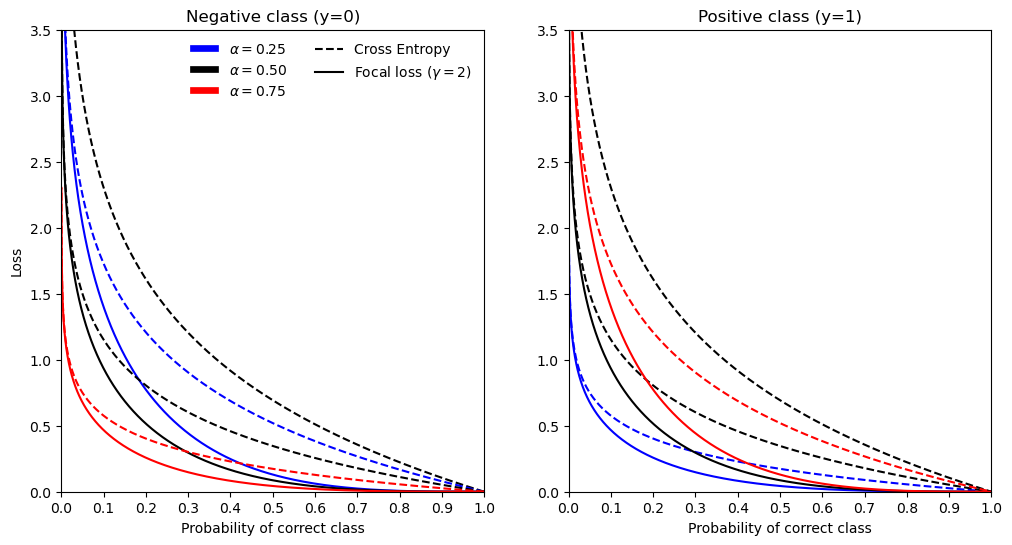

In [14]:
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

alpha_colors = ['b', 'k', 'r']
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x_neg = 1-x 
ax[0].plot(x_neg, loss_neg, color='k', linestyle='--')
for i, alpha in enumerate(alpha_vals):
    ax[0].plot(x_neg, focal_losses_neg[i], color=alpha_colors[i])
    ax[0].plot(x_neg, losses_negative[i], linestyle='--', color=alpha_colors[i]) 
ax[0].set_title('Negative class (y=0)')
ax[0].set_xlabel('Probability of correct class')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0, 3.5)
ax[0].set_xlim(0, 1)

ax[1].plot(x, loss_pos, color='k', linestyle='--')
for i, alpha in enumerate(alpha_vals):
    ax[1].plot(x, focal_losses_pos[i], color=alpha_colors[i])
    ax[1].plot(x, losses_positive[i], linestyle='--', color=alpha_colors[i]) 
ax[1].set_title('Negative class (y=0)')
ax[1].set_xlabel('Probability of correct class')
ax[1].set_title('Positive class (y=1)')
ax[1].set_xlabel('Probability of correct class')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
[ax[i].set_xticks(np.arange(0, 1.1, 0.1)) for i in range(2)]

ce = Line2D([0], [0], color='k', linestyle='--')
focal = Line2D([0], [0], color='k')
alpha_025 = Rectangle((0, 0), 1, 1, fc='b', edgecolor='b', linewidth=0.5)
alpha_050 = Rectangle((0, 0), 1, 1, fc='k', edgecolor='k', linewidth=0.5)
alpha_075 = Rectangle((0, 0), 1, 1, fc='r', edgecolor='r', linewidth=0.5)
handles = [alpha_025, alpha_050, alpha_075, ce, focal]
labels = [r'$\alpha=0.25$', r'$\alpha=0.50$', r'$\alpha=0.75$', 'Cross Entropy', fr'Focal loss ($\gamma={gamma}$)']
for i in range(2):
    ax[i].legend(handles, labels, loc='best', ncols=2, handlelength=2, handleheight=0.25, fontsize=10, frameon=False)
    if i == 1:
        ax[i].get_legend().remove()

plt.show()

## Experiment results

In [33]:
train_params = '0.75_0.75'
model_names = ['noPT_bce', 'noPT_gamma0.5', 'noPT_gamma1', 'noPT_gamma2', 'noPT_gamma4']
exp_folder = '2024-04-17_focal'
df_cv, df_diff = load_and_create_abs_and_rel_diff_dfs(train_params, model_names=model_names, 
                                                      exp_folder=exp_folder, ref_model=model_names[0])

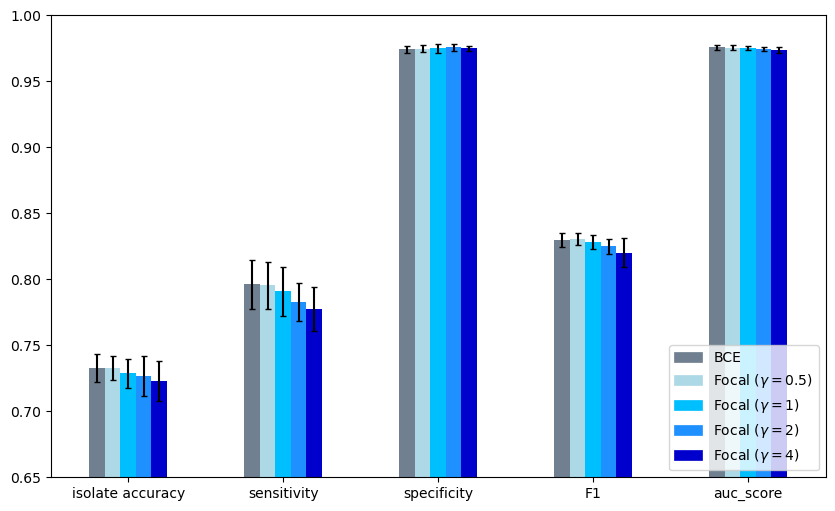

In [34]:
drop_metrics = ['accuracy', 'loss']
colors = ['slategray', 'lightblue', 'deepskyblue', 'dodgerblue', 'mediumblue']
fig, ax = plt.subplots(figsize=(10, 6))
df_cv.drop(drop_metrics).plot(kind='bar', y='avg', rot=0, yerr='std', capsize=2, color=colors, legend=False, ax=ax)
ax.set_xlabel('')

handles = [Rectangle((0,0), 1, 1, fc=colors[i], edgecolor=colors[i], linewidth=0.5) for i in range(len(model_names))]
labels = ['BCE', r'Focal ($\gamma=0.5$)', r'Focal ($\gamma=1$)', r'Focal ($\gamma=2$)', r'Focal ($\gamma=4$)']

ax.legend(handles, labels, loc='lower right')
ax.set_ylim(0.65, 1)
plt.show()

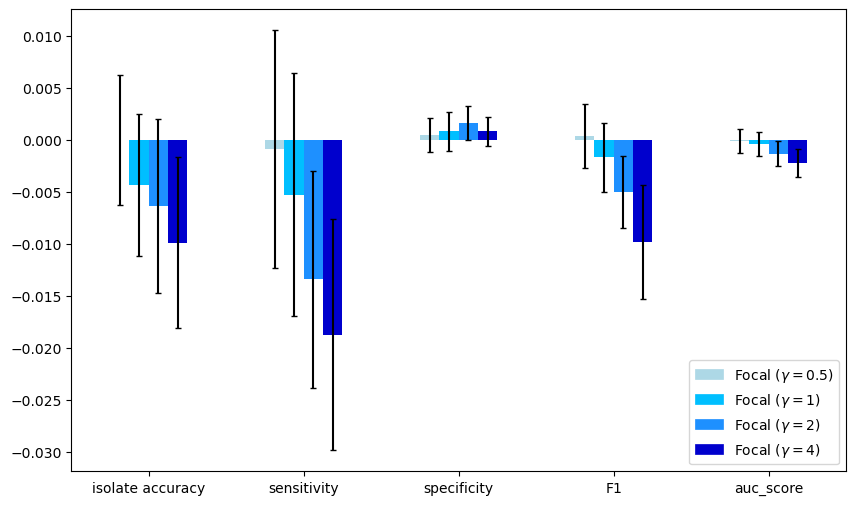

In [35]:
colors = ['slategray', 'lightblue', 'deepskyblue', 'dodgerblue', 'mediumblue']
fig, ax = plt.subplots(figsize=(10, 6))
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', rot=0, yerr='std', capsize=2, color=colors[1:], legend=False, ax=ax)
ax.set_xlabel('')

handles = [Rectangle((0,0), 1, 1, fc=colors[1:][i], edgecolor=colors[1:][i], linewidth=0.5) for i in range(len(model_names)-1)]
labels = [r'Focal ($\gamma=0.5$)', r'Focal ($\gamma=1$)', r'Focal ($\gamma=2$)', r'Focal ($\gamma=4$)']

ax.legend(handles, labels, loc='lower right')
plt.show()

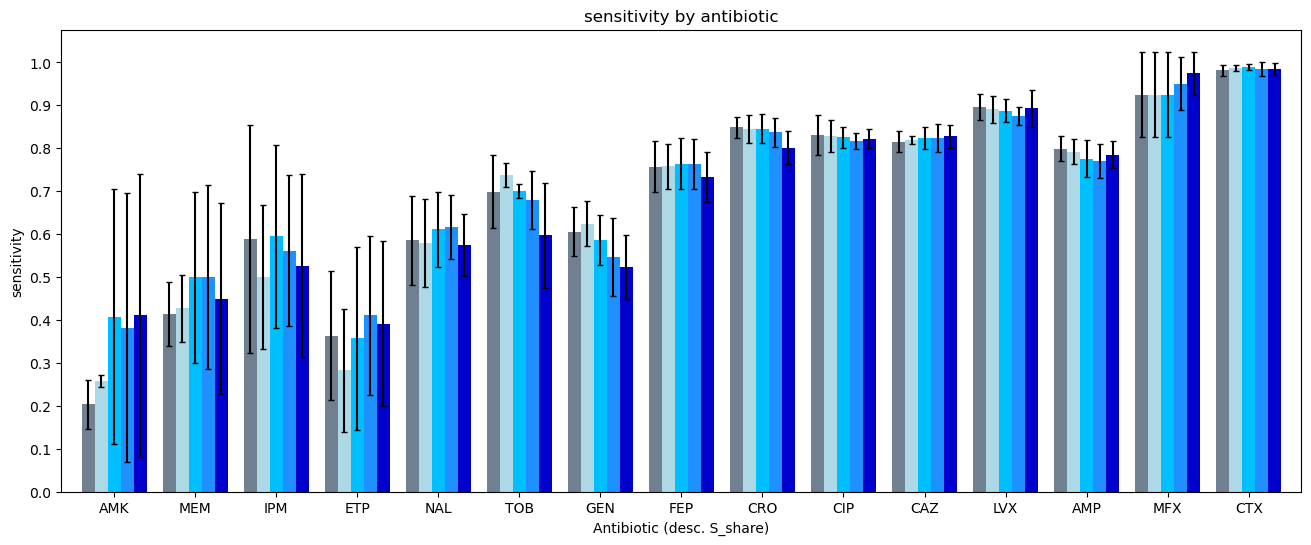

In [36]:
df_ab = load_and_create_ab_df(train_params, model_names=model_names, exp_folder=exp_folder)
plot_metric_by_ab(df_ab, 'sensitivity', sort_by_desc='S_share', bar_width=0.8, figsize=(16, 6), colors=colors, use_legend=False)

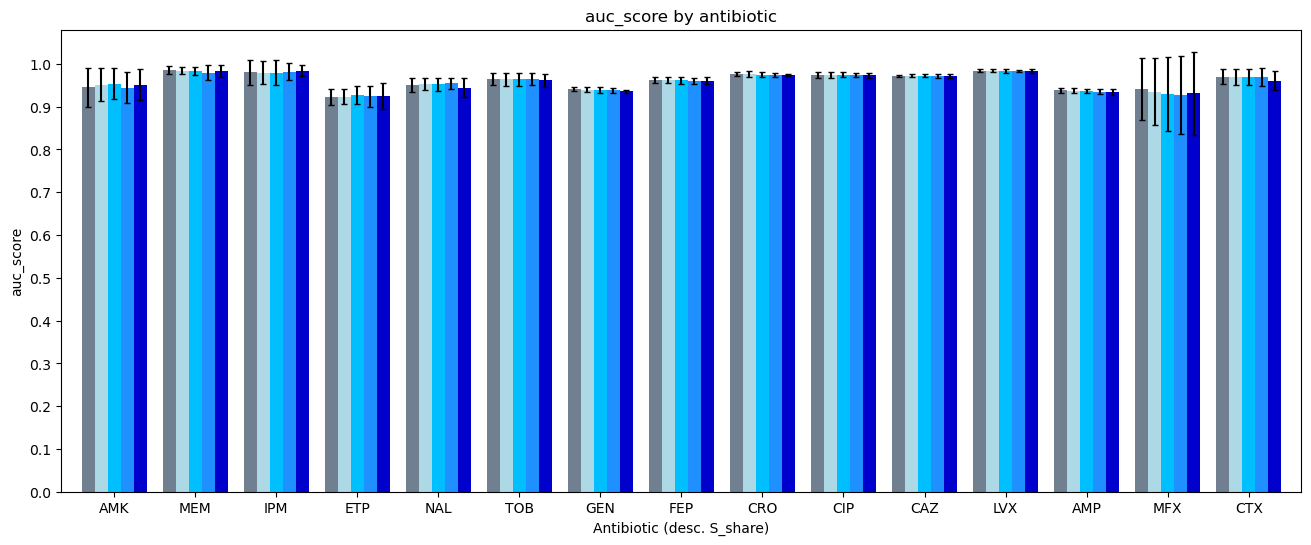

In [37]:
plot_metric_by_ab(df_ab, 'auc_score', sort_by_desc='S_share', bar_width=0.8, figsize=(16, 6), colors=colors, use_legend=False)

With weighted loss (alpha parameters)

In [38]:
train_params = '0.75_0.75'
model_names = ['noPT_bce_WL', 'noPT_gamma0.5_WL', 'noPT_gamma1_WL', 'noPT_gamma2_WL', 'noPT_gamma4_WL']
exp_folder = '2024-04-17_focal'
df_cv_wl, df_diff_wl = load_and_create_abs_and_rel_diff_dfs(train_params, model_names=model_names, exp_folder=exp_folder, ref_model=model_names[0])

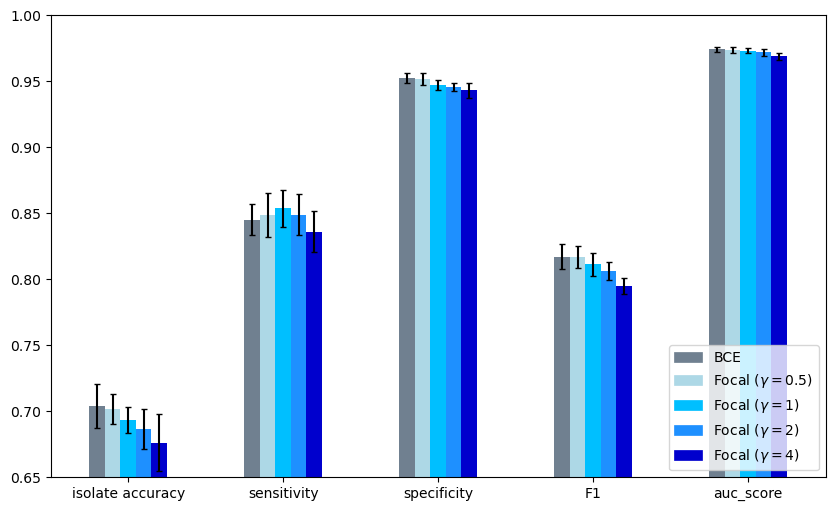

In [39]:
colors = ['slategray', 'lightblue', 'deepskyblue', 'dodgerblue', 'mediumblue']
fig, ax = plt.subplots(figsize=(10, 6))
df_cv_wl.drop(drop_metrics).plot(kind='bar', y='avg', rot=0, yerr='std', capsize=2, color=colors, legend=False, ax=ax)
ax.set_xlabel('')

handles = [Rectangle((0,0), 1, 1, fc=colors[i], edgecolor=colors[i], linewidth=0.5) for i in range(len(model_names))]
labels = ['BCE', r'Focal ($\gamma=0.5$)', r'Focal ($\gamma=1$)', r'Focal ($\gamma=2$)', r'Focal ($\gamma=4$)']

ax.legend(handles, labels, loc='lower right')
ax.set_ylim(0.65, 1)
plt.show()

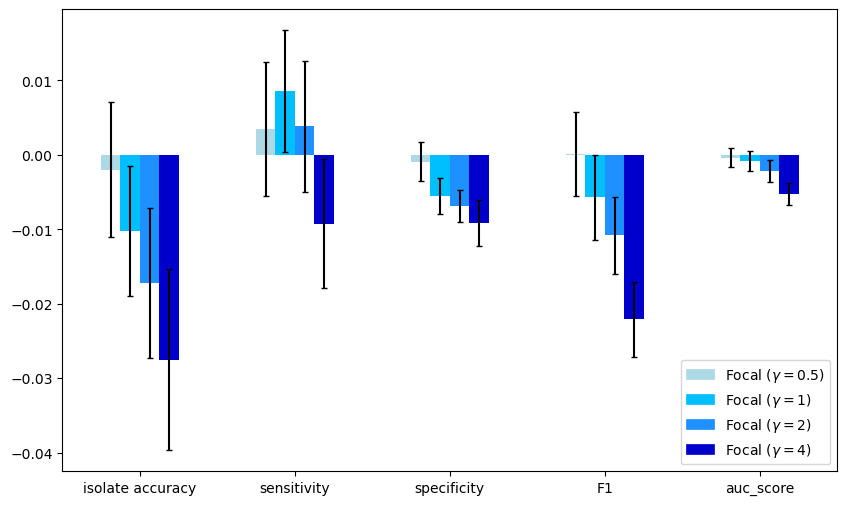

In [40]:
colors = ['slategray', 'lightblue', 'deepskyblue', 'dodgerblue', 'mediumblue']
fig, ax = plt.subplots(figsize=(10, 6))
df_diff_wl.drop(drop_metrics).plot(kind='bar', y='avg', rot=0, yerr='std', capsize=2, color=colors[1:], legend=False, ax=ax)
ax.set_xlabel('')

handles = [Rectangle((0,0), 1, 1, fc=colors[1:][i], edgecolor=colors[1:][i], linewidth=0.5) for i in range(len(model_names)-1)]
labels = [r'Focal ($\gamma=0.5$)', r'Focal ($\gamma=1$)', r'Focal ($\gamma=2$)', r'Focal ($\gamma=4$)']

ax.legend(handles, labels, loc='lower right')
plt.show()

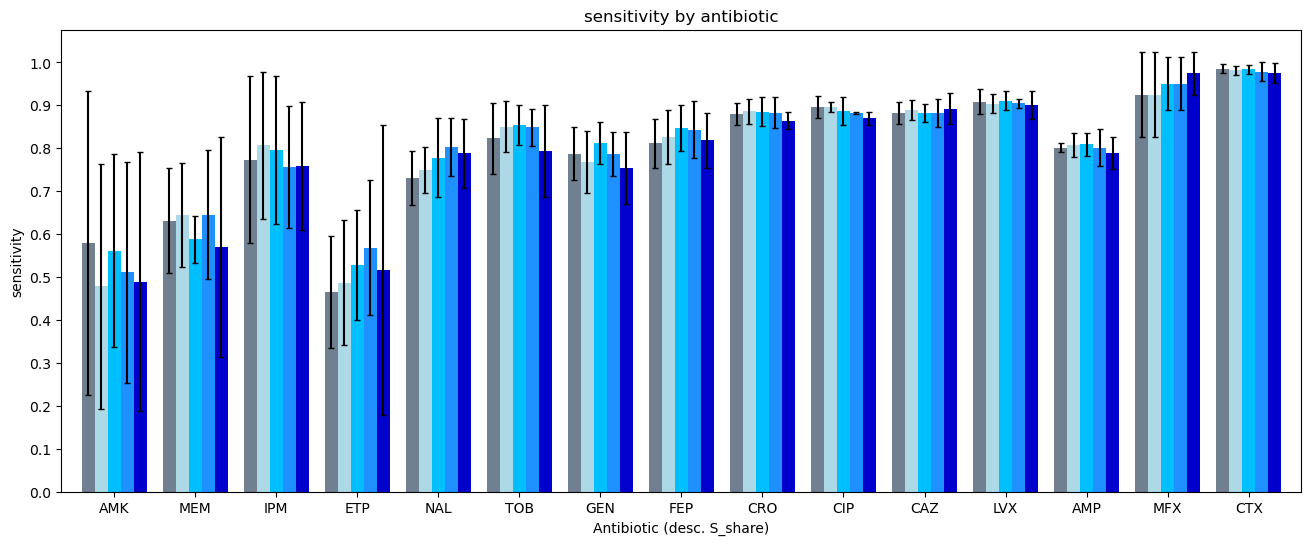

In [41]:
df_ab = load_and_create_ab_df(train_params, model_names=model_names, exp_folder=exp_folder)
plot_metric_by_ab(df_ab, 'sensitivity', sort_by_desc='S_share', bar_width=0.8, figsize=(16, 6), colors=colors, use_legend=False)

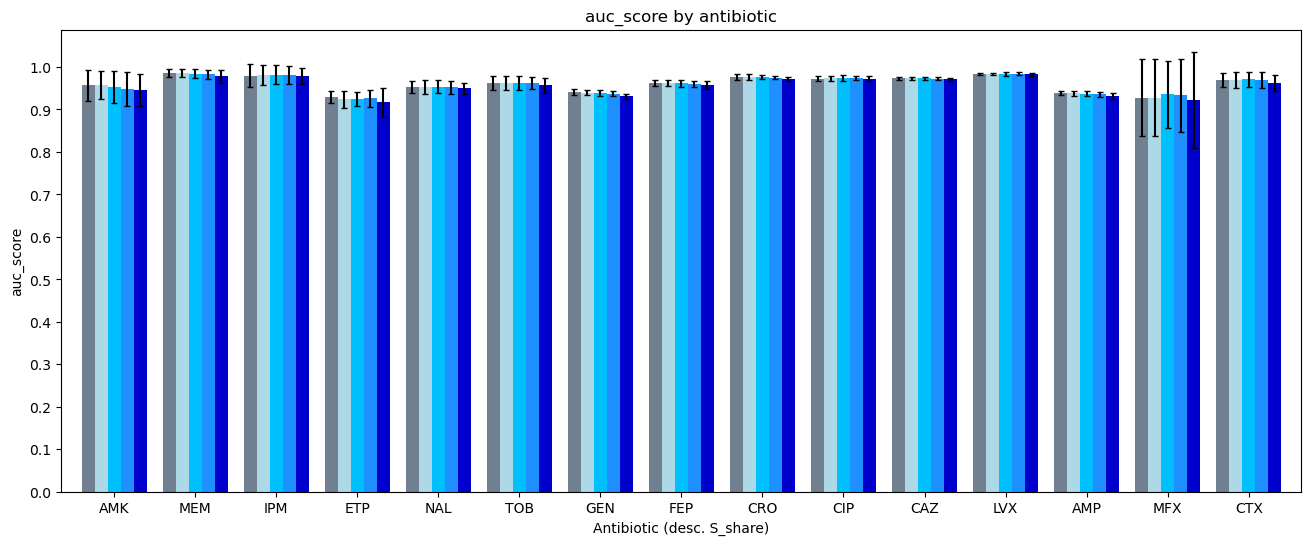

In [42]:
plot_metric_by_ab(df_ab, 'auc_score', sort_by_desc='S_share', bar_width=0.8, figsize=(16, 6), colors=colors, use_legend=False)

## TEMP

In [43]:
results = pd.read_pickle('results/MM/FT_test_AUC/CV_results.pkl')
roc = results['roc_results']
fpr, tpr, thresholds, auc_score = roc[0].values()

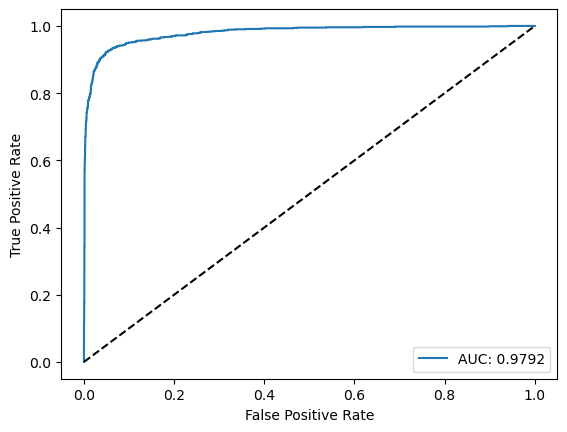

In [44]:
plt.plot(fpr, tpr, label=f'AUC: {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [45]:
best_idx = np.argmax(tpr-fpr)
best_threshold = thresholds[best_idx]
print(f"Best threshold: {best_threshold:.4f}")
tpr[best_idx], fpr[best_idx]

Best threshold: 0.4523


(0.921765295887663, 0.048190401258851295)

In [46]:
df_CV = get_average_and_std_df(results)
df_CV

,avg,std
metric,,
loss,0.058107,0.004529
accuracy,0.955101,0.005531
isolate accuracy,0.875444,0.013456
sensitivity,0.908009,0.008717
specificity,0.963211,0.006851
F1,0.856745,0.010091


In [47]:
df_CV_ab = get_ab_stats_df(results, with_ab_as_index=True)
df_CV_ab

,avg_num,std_num,S_share_median,R_share_median,S_share_std,R_share_std,accuracy_avg,accuracy_std,sensitivity_avg,sensitivity_std,specificity_avg,specificity_std,precision_avg,precision_std,F1_avg,F1_std
antibiotic,,,,,,,,,,,,,,,,
AMK,402,8.466847,0.990000,0.010000,0.000206,0.000206,0.988207,0.003640,0.125000,0.125000,0.996874,0.004133,0.400000,0.432049,0.311111,0.088889
AMP,369,3.535534,0.606684,0.393316,0.025355,0.025355,0.960705,0.004912,0.939915,0.011699,0.974499,0.008908,0.959042,0.016943,0.949238,0.008577
CAZ,415,6.670832,0.715796,0.284204,0.026753,0.026753,0.924293,0.012256,0.912041,0.040653,0.930455,0.017021,0.843582,0.028436,0.875237,0.011196
CIP,727,9.093267,0.857655,0.142345,0.015417,0.015417,0.957064,0.006078,0.933064,0.026356,0.961377,0.009286,0.807012,0.036456,0.864336,0.010172
CRO,601,11.800424,0.808137,0.191863,0.026047,0.026047,0.957592,0.007504,0.939440,0.033846,0.963472,0.008916,0.865921,0.037626,0.900031,0.016430
CTX,99,7.176350,0.138361,0.861639,0.017367,0.017367,0.975572,0.016365,0.996835,0.005481,0.843143,0.121492,0.975653,0.019548,0.986005,0.009434
ETP,383,17.102631,0.970849,0.029151,0.007654,0.007654,0.961091,0.008274,0.432108,0.092291,0.977914,0.007086,0.395685,0.085283,0.406363,0.076841
FEP,417,11.715375,0.797995,0.202005,0.020698,0.020698,0.885185,0.015040,0.900116,0.038437,0.881318,0.020548,0.649778,0.059595,0.752988,0.043311
GEN,624,6.652067,0.885895,0.114105,0.007836,0.007836,0.954727,0.003553,0.829130,0.067217,0.970951,0.012577,0.795427,0.067001,0.806584,0.014936


In [48]:
results['ab_stats'][0].iloc[0]

antibiotic                                                      AMK
num_masked_tot                                                  393
num_masked_S                                                    389
num_masked_R                                                      4
num_pred_S                                                      393
num_pred_R                                                        0
num_correct                                                     389
num_correct_S                                                   389
num_correct_R                                                     0
accuracy                                                   0.989822
sensitivity                                                     0.0
specificity                                                     1.0
precision                                                       NaN
F1                                                              NaN
auc_score                                       

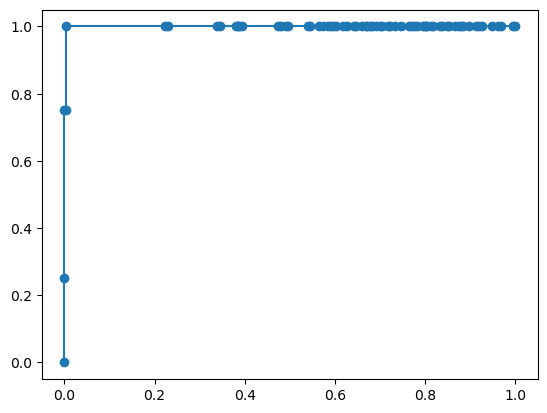

In [49]:
fpr_0 = results['ab_stats'][0].iloc[0].loc['roc_fpr']
tpr_0 = results['ab_stats'][0].iloc[0].loc['roc_tpr']
thresholds_0 = results['ab_stats'][0].iloc[0].loc['roc_thresholds']
plt.plot(fpr_0, tpr_0, '-o', label='Model 0')

In [50]:
fpr_0, tpr_0, thresholds_0

(array([0.        , 0.        , 0.        , 0.00257069, 0.00257069,
        0.22365039, 0.22879177, 0.33933162, 0.34447301, 0.38046272,
        0.38560411, 0.38817481, 0.3933162 , 0.47300771, 0.48071979,
        0.49100257, 0.49614396, 0.53984576, 0.54498715, 0.5655527 ,
        0.57326478, 0.58354756, 0.59125964, 0.59640103, 0.60154242,
        0.61696658, 0.62724936, 0.64267352, 0.64781491, 0.66066838,
        0.66838046, 0.67095116, 0.67866324, 0.68123393, 0.69151671,
        0.69922879, 0.70437018, 0.71722365, 0.72236504, 0.73264781,
        0.74550129, 0.76349614, 0.76863753, 0.77634961, 0.781491  ,
        0.79434447, 0.79691517, 0.80205656, 0.80462725, 0.81233933,
        0.81748072, 0.83290488, 0.83804627, 0.84832905, 0.85347044,
        0.86632391, 0.87403599, 0.87917738, 0.88431877, 0.89717224,
        0.9125964 , 0.92030848, 0.92544987, 0.94858612, 0.96143959,
        0.96915167, 0.99485861, 1.        ]),
 array([0.  , 0.25, 0.75, 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.

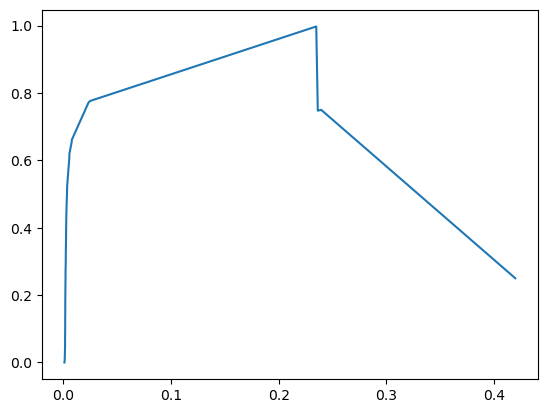

In [51]:
plt.plot(thresholds_0, tpr_0-fpr_0, label='Model 0')